In [95]:
import numpy as np
import matplotlib.pyplot as plt


In [96]:
loss = nn.MSELoss()
input1 = torch.randn(100, 1,28,28)
input2 = torch.randn(100, 1,28,28)
output = loss(input1, input2)
output

tensor(2.0059)

In [97]:
import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [98]:
# load data

with np.load('denoising-challenge-01-data.npz') as fh:
    training_images_clean = torch.tensor(fh['training_images_clean'])
    validation_images_noisy = torch.tensor(fh['validation_images_noisy'])
    validation_images_clean = torch.tensor(fh['validation_images_clean'])
    test_images_noisy = torch.tensor(fh['test_images_noisy'])

# TRAINING DATA: CLEAN
# 1. INDEX: IMAGE SERIAL NUMBER (20000)
# 2. INDEX: COLOR CHANNEL (1)
# 3/4. INDEX: PIXEL VALUE (28 x 28)
print("training_images", training_images_clean.shape, training_images_clean.dtype)

# VALIDATION DATA: CLEAN + NOISY
print("validation_clean", validation_images_clean.shape, validation_images_clean.dtype)
print("validation_noise",validation_images_noisy.shape, validation_images_noisy.dtype)

# TEST DATA: NOISY
print("test_images", test_images_noisy.shape, test_images_noisy.dtype)

# TRAIN MODEL ON training_images_clean

# CHECK YOUR MODEL USING (validation_images_clean, validation_images_noisy)

# DENOISE IMAGES (test_images_clean) USING test_images_noisy

# # MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
# assert test_images_clean.ndim == 4
# assert test_images_clean.shape[0] == 2000
# assert test_images_clean.shape[1] == 1
# assert test_images_clean.shape[2] == 28
# assert test_images_clean.shape[3] == 28
# 
# # AND SAVE EXACTLY AS SHOWN BELOW
# np.save('test_images_clean.npy', test_images_clean)

training_images torch.Size([20000, 1, 28, 28]) torch.float32
validation_clean torch.Size([2000, 1, 28, 28]) torch.float32
validation_noise torch.Size([2000, 1, 28, 28]) torch.float32
test_images torch.Size([2000, 1, 28, 28]) torch.float32


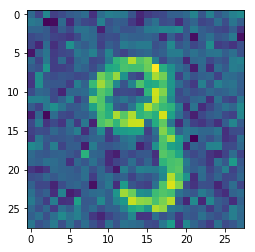

In [99]:
# check one image
plt.imshow(validation_images_noisy[5,0])

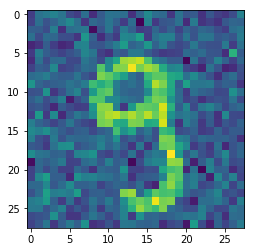

In [100]:
plt.imshow((validation_images_clean[5,0] + 0.22 *
                   (torch.normal(0,std=torch.ones_like(training_images_clean))
                    ))[1,0])


In [101]:
# create directories

# if not os.path.exists('C:\\tmp\\autoencoder'):
#     os.mkdir('C:\\tmp\\autoencoder')
# if not os.path.exists('C:\\tmp\\autoencoder\\mlp_img'):
#     os.mkdir('C:\\tmp\\autoencoder\\mlp_img')


# helper function

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


In [102]:
# MODEL

class autoencoder(nn.Module):
    # model
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64))#,
            # nn.ReLU(True), 
            # nn.Linear(64, 12), 
            # nn.ReLU(True), 
            # nn.Linear(12, 3))
        
        self.decoder = nn.Sequential(
            # nn.Linear(3, 12),
            # nn.ReLU(True),
            # nn.Linear(12, 64),
            # nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [103]:
# variables
num_epochs = 100
batch_size = 128
# parameter = 1.


# hyperparameter optimization
hy_parameter1 = np.array([0.22,1]) # np.arange(22,31,3)*0.01
validation_loss_arr = np.zeros_like(hy_parameter1)
training_loss_arr = np.zeros_like(hy_parameter1)

for parameter in hy_parameter1:
    if parameter==1:
        break
    counter = 0
    
    #print('for the distribution parameter: {:.2f}'.format(parameter))

    # =========INI MODEL=========
    # creating the pytorch instances
    model = autoencoder()
    # load trained model
    # model.load_state_dict(torch.load('C:\\tmp\\autoencoder\\autoencoder.pth'))

    # define optimizer and loss function
    learning_rate = 1e-3
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-5)


    # =========TRAINING=========
    # workflow
    for epoch in range(num_epochs):
        dataset = torch.tensor

        # prep data for pytorch format  ######### have to shuffel clean data with noise
        # applying noramal distribution
        #### torch.tensor(np.zeros((3,2,1)))
        #dataset = torch.tensor(np.zeros((training_images_clean.shape[0],
        #                                 2,
        #                                 training_images_clean.shape[2],
        #                                 training_images_clean.shape[3])))
        ####
        dataset = ((training_images_clean + parameter *
                   (torch.normal(0,std=torch.ones_like(training_images_clean)))),
                   training_images_clean
                  )
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        data_counter = 0
        
        for data in dataloader:

            # prep data for pytorch
            img, img_clean = data
            img, img_clean = img.view(img.size(0), -1), img_clean.view(img_clean.size(0),-1)


            # ===================forward=====================
            output = model(img)
            loss = criterion(output, img_clean)


            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            data_counter += 1


        # ===================log========================
        # print('epoch [{}/{}], loss:{:.4f}'
        #       .format(epoch + 1, num_epochs, loss.data[0]))

        # if epoch % 10 == 0:
        #     pic = to_img(output.cpu().data)
        #     save_image(pic, 'c:\\tmp\\autoencoder\\image_{}.png'.format(epoch))
    
    training_loss_arr[counter] = loss.data[0]



    # =========VALIDATION=========
    # prep data
    dataset_val_noise = validation_images_noisy
    dataset_val_clean = validation_images_clean

    # workflow
    with torch.no_grad():
        
        loss_val = 0
        
        for i in range(dataset_val_noise.shape[0]):

            # prep data for pytorch
            img = dataset_val_noise[i]
            img = img.view(img.size(0), -1)

            img_clean = dataset_val_clean[i]
            img_clean = img_clean.view(img_clean.size(0), -1)


            # ===================forward=====================
            output = model(img)
            loss = criterion(output, img_clean)


            # # ===================backward====================
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()

            # ====================loss=======================
            loss_val += np.sqrt(np.sum((output.numpy()-img_clean.numpy())**2))


        # ===================log========================
        loss_val /= 2000
        validation_loss_arr[counter] = loss_val
        counter += 1
        # print('validation loss:{:.4f}'.format(loss.data[0]))
        print('distribution parameter: {:.4f}'.format(parameter),
              '    proper validation loss:{:.4f}'.format(loss_val))
        
    # saving trained model
    filepath = 'C:\\tmp\\autoencoder\\autoencoder_{}_{}.pth'.format(parameter,num_epochs)


/storage/schuch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


distribution parameter: 0.2200     proper validation loss:5.1320
